In [61]:
from tifffile import imread
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import skimage.io as io
from pynndescent import NNDescent
from tqdm import tqdm, trange

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import LinearSegmentedColormap

cmap = {'MES-like': np.array([0.95686275, 0.69019608, 0.7372549]), #'pink',
 'DC': np.array([0.6823529411764706,0.7803921568627451,0.9098039215686274]),
 'CD4/CD8': np.array([1.0, 0.4980392156862745, 0.054901960784313725]),
 'Endothelial': np.array([1.0, 0.7333333333333333, 0.47058823529411764]),
 'Astrocyte': np.array([0.17254901960784313,0.6274509803921569,0.17254901960784313]),
 'AC-like': np.array([0.26666667, 0.48627451, 0.41176471]), #'#447c69',
 'Mast': np.array([1.0, 0.596078431372549, 0.5882352941176471]),
 'Mono': np.array([0.5803921568627451, 0.403921568627451, 0.741176470588235]),
 'Mural cell': np.array([0.7725490196078432,0.6901960784313725,0.8352941176470589]),
 'NK': np.array([0.5490196078431373, 0.33725490196078434, 0.29411764705882354]),
 'NPC-like': np.array([0.3254902 , 0.51764706, 0.85882353]), #'#5384db',
 'OPC-like': np.array([0.61176471, 0.72941176, 0.0980392]), #'#9cba19',
 'RG': np.array([0.4980392156862745, 0.4980392156862745, 0.4980392156862745]),
 'TAM-BDM': np.array([0.4580392156862745, 0.4580392156862745, 0.4580392156862745]),
 'OPC': np.array([0.7372549019607844, 0.7411764705882353, 0.13333333333333333]),
 'Oligodendrocyte': np.array([0.8588235294117647, 0.8588235294117647, 0.5529411764705883]),
 'TAM-MG': np.array([0.09019607843137255, 0.7450980392156863, 0.8117647058823529])}

In [35]:
path_adata = '../..' ## Change path to anndata folder
adata = sc.read(path_adata + 'GBM_annotated.h5ad')
adata.uns['log1p']["base"] = None

/home/camiel/anaconda3/envs/embryoscope2/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Identify Vessel structures

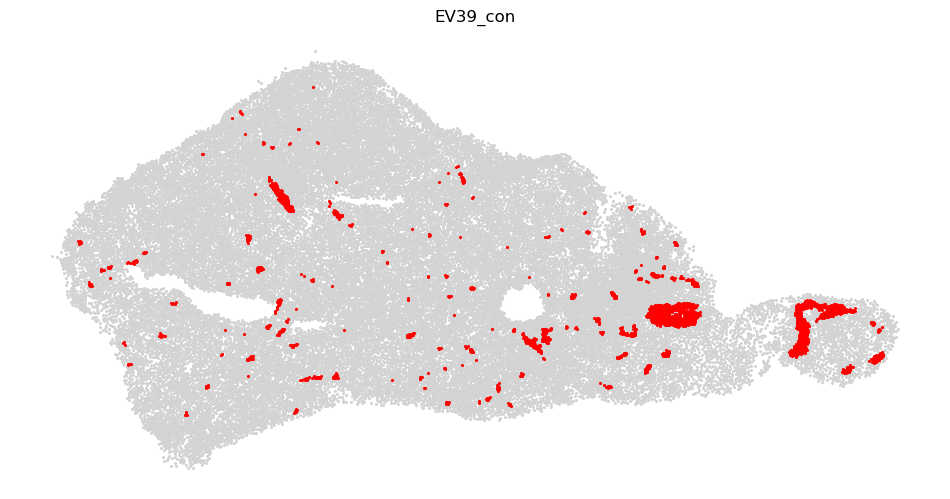

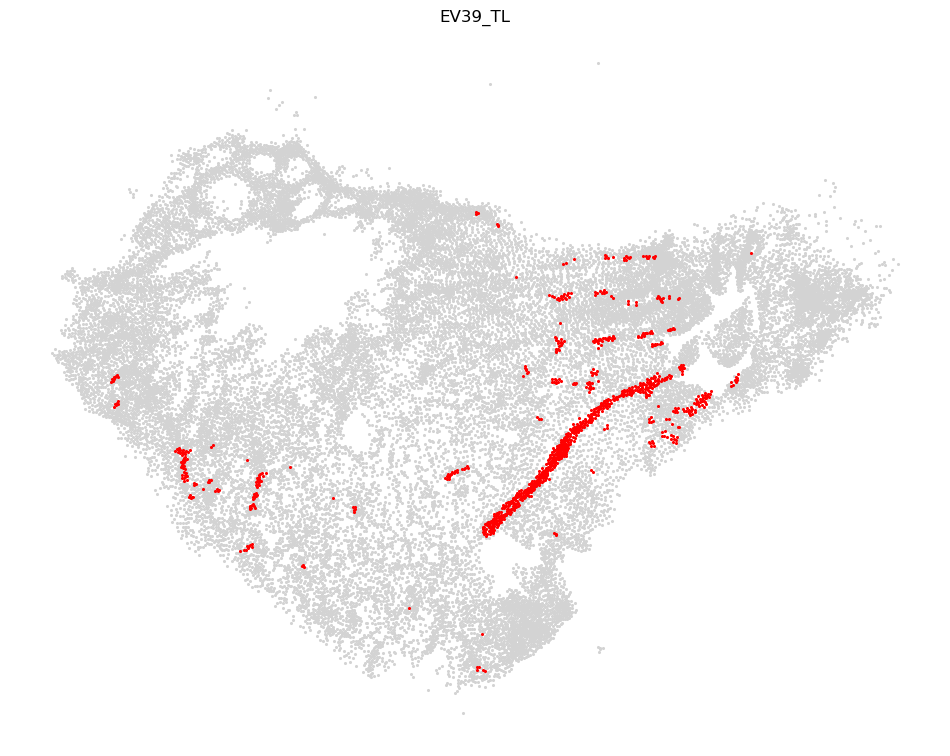

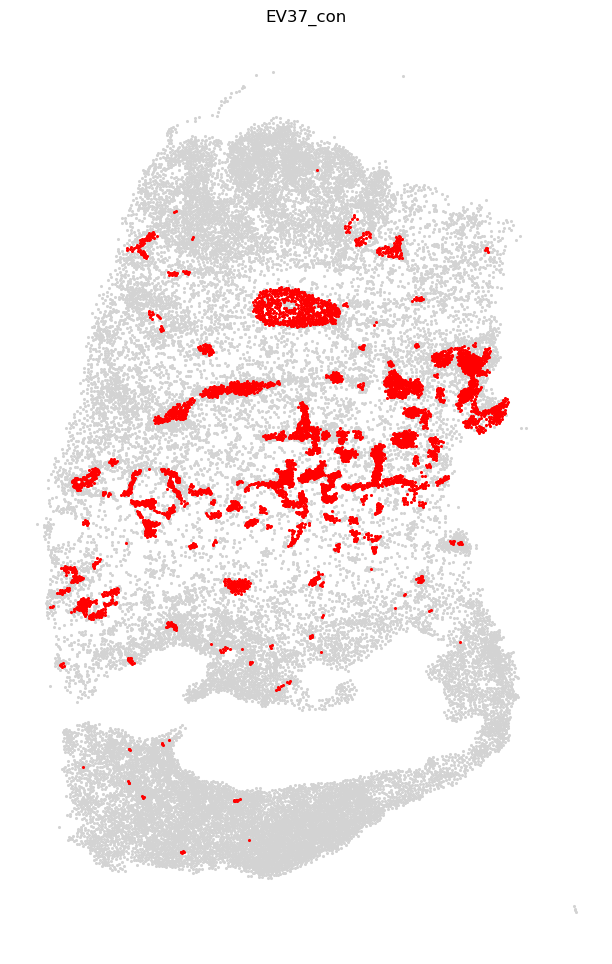

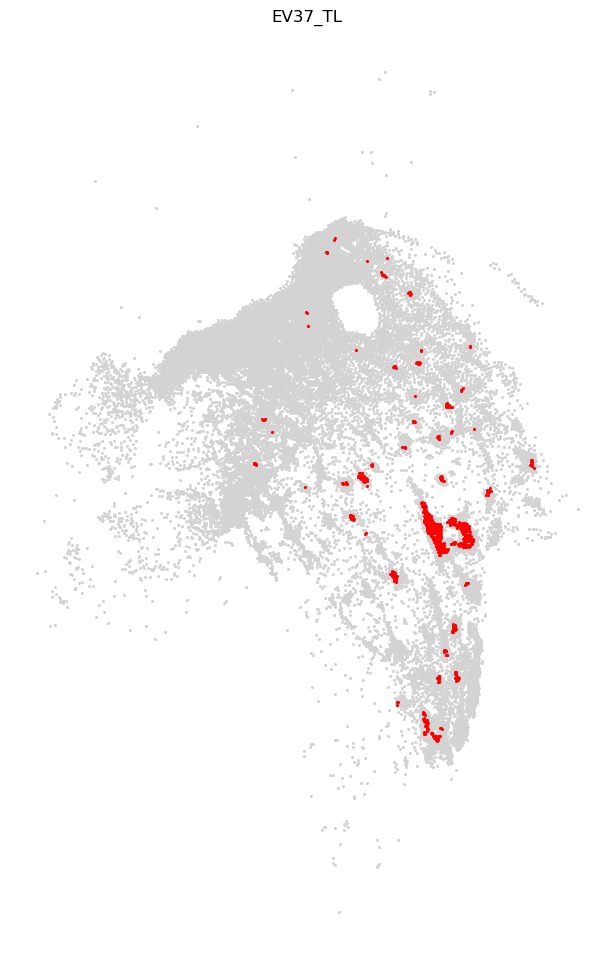

In [42]:
mn_ves = 5
k = 8
ref_cluster = ['5', '7']
key = 'louvain_1_0'

ID_replicates = {'EV39_con': ['EV39_con'],
                 'EV39_TL': ['EV39_TL_A'],
                 'EV37_con': ['EV37_con'],
                 'EV37_TL': ['EV37_TL']}

adatasubs = {}

for ID in ID_replicates:
    replicates = ID_replicates[ID]
    adatasub=adata[[x in replicates for x in adata.obs['replicate']]].copy()

    if ID in ['EV39_TL', 'EV37_TL']:
        YX = np.vstack([adatasub.obs.Y_transformed, adatasub.obs.X_transformed]).T
    else:
        YX = np.vstack([adatasub.obs.Y, adatasub.obs.X]).T
    endo_per = np.array([x in ref_cluster for x in adatasub.obs[key]])
    index = NNDescent(YX)
    idx, distance = index.query(YX, k=k)
    
    ves = (np.sum(endo_per[idx], 1) > mn_ves) & endo_per
    
    ## Index ves
    index_ves = NNDescent(YX[ves,:])
    
    idx, distance = index_ves.query(YX, k=10)
    adatasub.obs['distance_to_vessel'] = np.min(distance,1)
    adatasubs[ID] = adatasub.copy()
    
    plt.figure(figsize=(12,12))
    plt.scatter(YX[~ves,1], YX[~ves,0], s=5, lw=0, c='lightgrey')
    plt.scatter(YX[ves,1], YX[ves,0], s=5, lw=0, c='red')
    plt.axis('off')
    plt.gca().set_aspect('equal')
    plt.title(ID)

## Distance to vessel

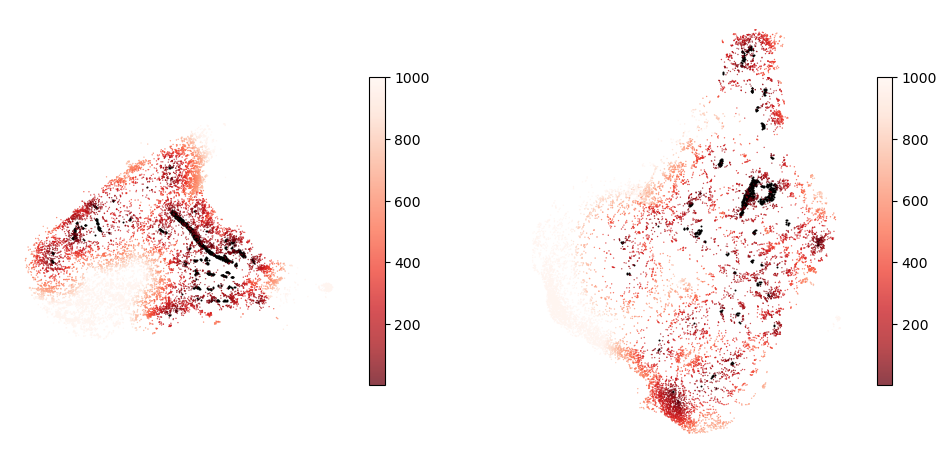

In [58]:
fig, ax = plt.subplots(1,2,figsize=(12,8))

## EV39
df = pd.read_csv('data/EV39_metrics.csv')
start = np.load('data/EV39_start.npy')
YX = np.vstack([adatasubs['EV39_TL'].obs.Y_transformed, adatasubs['EV39_TL'].obs.X_transformed]).T
ves = adatasubs['EV39_TL'].obs.distance_to_vessel == 0

ax[0].scatter(YX[ves,1], YX[ves,0], s=2, lw=0, c='black', alpha=1)
dplot = ax[0].scatter(start[:,1], start[:,0], lw=0, s=1, c=df.Distance_vessel_start, cmap='Reds_r', vmax=1000, alpha=.75)
ax[0].invert_yaxis();
cb = fig.colorbar(dplot, ax=ax[0], shrink=.5, orientation="vertical")
ax[0].axis('off');
ax[0].set_aspect('equal')

## EV37
df = pd.read_csv('data/EV37_metrics.csv')
start = np.load('data/EV37_start.npy')
YX = np.vstack([adatasubs['EV37_TL'].obs.Y_transformed, adatasubs['EV37_TL'].obs.X_transformed]).T
ves = adatasubs['EV37_TL'].obs.distance_to_vessel == 0

ax[1].scatter(YX[ves,1], YX[ves,0], s=2, lw=0, c='black', alpha=1)
dplot = ax[1].scatter(start[:,1], start[:,0], lw=0, s=1, c=df.Distance_vessel_start, cmap='Reds_r', vmax=1000, alpha=.75)
ax[1].invert_yaxis();
cb = fig.colorbar(dplot, ax=ax[1], shrink=.5, orientation="vertical")
ax[1].axis('off');
ax[1].set_aspect('equal')

## Tracks on vessel

(3750.0, 4750.0)

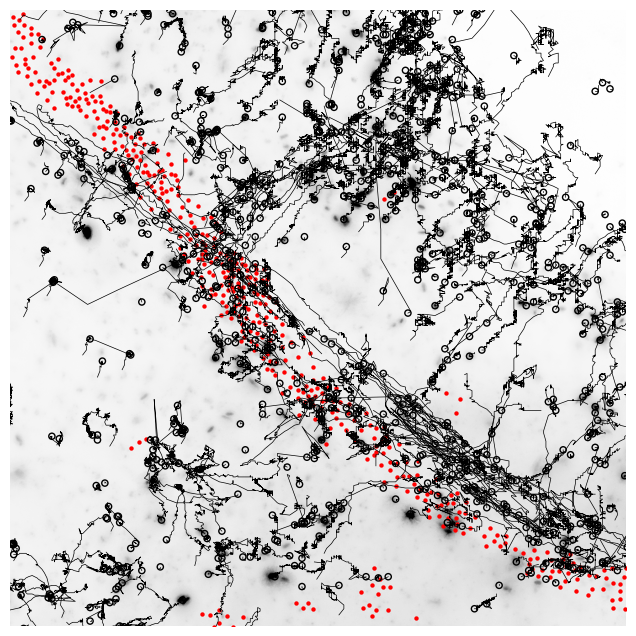

In [68]:
roi = [3750, 4750, 2250,3250]
s = 15

YX = np.vstack([adatasubs['EV39_TL'].obs.Y_transformed, adatasubs['EV39_TL'].obs.X_transformed]).T
ves = adatasubs['EV39_TL'].obs.distance_to_vessel == 0

tracks = np.load('data/EV39_tracks.npy')

im = imread('data/EV39_last_timestep.tif')
bg_mask = im == np.min(im)
mn = np.min(im[~bg_mask])
im[bg_mask] = mn

plt.figure(figsize=(8,8))
plt.imshow(im, cmap='Greys')
plt.axis('off');

plt.scatter(YX[ves,1], YX[ves,0]-100, s=10, lw=0, c='red')
plt.axis('off')

in_y = np.unique(np.where((tracks[:,0,:] > roi[2]) & (tracks[:,0,:] < roi[3]))[0])
in_x = np.unique(np.where((tracks[:,1,:] > roi[0]) & (tracks[:,1,:] < roi[1]))[0])
valid_cells = set([x for x in in_y if x in in_x])

t = tracks.shape[-1]
for i in range(tracks.shape[0]):
    if i in valid_cells:
        xy = tracks[i,:,:].reshape([2,t])
        valid = xy[1,:] > 0
        plt.plot(xy[1,valid], xy[0,valid], c='black', lw=.5, alpha=1)
        plt.scatter(xy[1,np.where(valid)[0][-1]], xy[0,np.where(valid)[0][-1]], s=20, facecolors='none', edgecolors = 'black')

plt.ylim([roi[3],roi[2]])
plt.xlim([roi[0],roi[1]])

(3650.0, 4650.0)

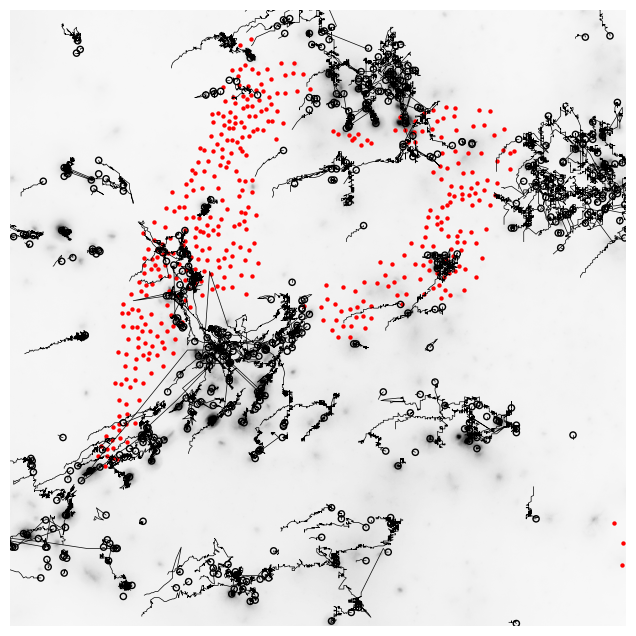

In [69]:
roi = [3650, 4650, 2650,3650]
s = 15

YX = np.vstack([adatasubs['EV37_TL'].obs.Y_transformed, adatasubs['EV37_TL'].obs.X_transformed]).T
ves = adatasubs['EV37_TL'].obs.distance_to_vessel == 0

tracks = np.load('data/EV37_tracks.npy')

im = imread('data/EV37_last_timestep.tif')
bg_mask = im == np.min(im)
mn = np.min(im[~bg_mask])
im[bg_mask] = mn

plt.figure(figsize=(8,8))
plt.imshow(im, cmap='Greys')
plt.axis('off');

plt.scatter(YX[ves,1], YX[ves,0]-100, s=10, lw=0, c='red')
plt.axis('off')

in_y = np.unique(np.where((tracks[:,0,:] > roi[2]) & (tracks[:,0,:] < roi[3]))[0])
in_x = np.unique(np.where((tracks[:,1,:] > roi[0]) & (tracks[:,1,:] < roi[1]))[0])
valid_cells = set([x for x in in_y if x in in_x])

t = tracks.shape[-1]
for i in range(tracks.shape[0]):
    if i in valid_cells:
        xy = tracks[i,:,:].reshape([2,t])
        valid = xy[1,:] > 0
        plt.plot(xy[1,valid], xy[0,valid], c='black', lw=.5, alpha=1)
        plt.scatter(xy[1,np.where(valid)[0][-1]], xy[0,np.where(valid)[0][-1]], s=20, facecolors='none', edgecolors = 'black')

plt.ylim([roi[3],roi[2]])
plt.xlim([roi[0],roi[1]])

(3750.0, 4750.0)

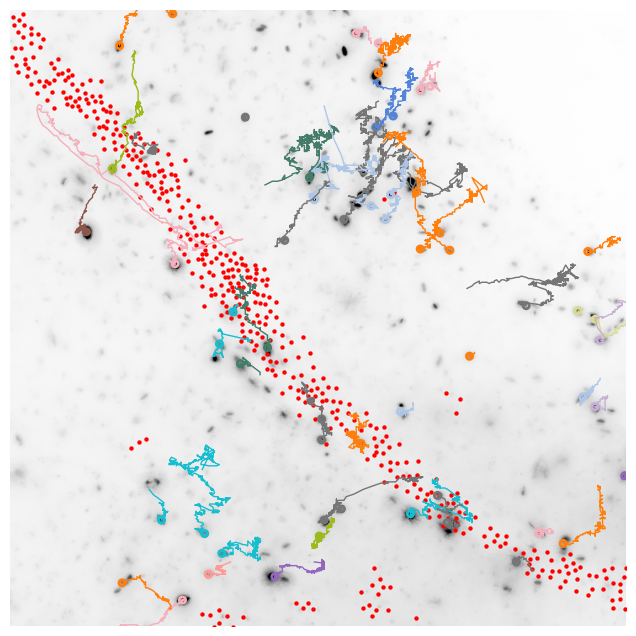

In [79]:
roi = [3750, 4750, 2250,3250]
s = 15

YX = np.vstack([adatasubs['EV39_TL'].obs.Y_transformed, adatasubs['EV39_TL'].obs.X_transformed]).T
ves = adatasubs['EV39_TL'].obs.distance_to_vessel == 0

tracks = np.load('data/EV39_tracks.npy')
df = pd.read_csv('data/EV39_metrics.csv')

im = imread('data/EV39_last_timestep.tif')
bg_mask = im == np.min(im)
mn = np.min(im[~bg_mask])
im[bg_mask] = mn

plt.figure(figsize=(8,8))
plt.imshow(im, cmap='Greys')
plt.axis('off');

plt.scatter(YX[ves,1], YX[ves,0]-100, s=10, lw=0, c='red')

in_y = np.unique(np.where((tracks[:,0,:] > roi[2]) & (tracks[:,0,:] < roi[3]))[0])
in_x = np.unique(np.where((tracks[:,1,:] > roi[0]) & (tracks[:,1,:] < roi[1]))[0])
valid_cells = set([x for x in in_y if x in in_x])

t = tracks.shape[-1]
for i in np.where(df.Aligned_to_Xenium)[0]:
    if i in valid_cells:
        xy = tracks[i,:,:].reshape([2,t])
        valid = xy[1,:] > 0
        plt.plot(xy[1,valid], xy[0,valid], c=cmap[df.Labels_GBMap[i]], lw=1, alpha=1)
        plt.scatter(xy[1,np.where(valid)[0][-1]], xy[0,np.where(valid)[0][-1]], s=20, facecolors='none', edgecolors = cmap[df.Labels_GBMap[i]], lw=2)

plt.ylim([roi[3],roi[2]])
plt.xlim([roi[0],roi[1]])

(3650.0, 4650.0)

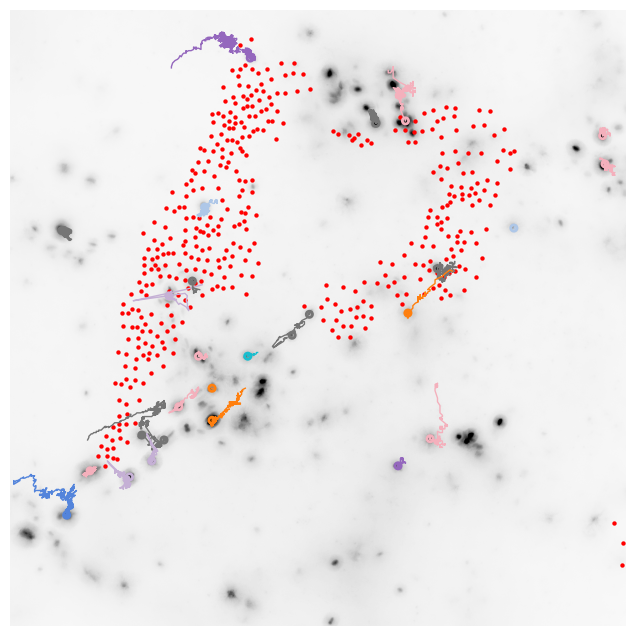

In [80]:
roi = [3650, 4650, 2650,3650]
s = 15

YX = np.vstack([adatasubs['EV37_TL'].obs.Y_transformed, adatasubs['EV37_TL'].obs.X_transformed]).T
ves = adatasubs['EV37_TL'].obs.distance_to_vessel == 0

tracks = np.load('data/EV37_tracks.npy')
df = pd.read_csv('data/EV37_metrics.csv')

im = imread('data/EV37_last_timestep.tif')
bg_mask = im == np.min(im)
mn = np.min(im[~bg_mask])
im[bg_mask] = mn

plt.figure(figsize=(8,8))
plt.imshow(im, cmap='Greys')
plt.axis('off');

plt.scatter(YX[ves,1], YX[ves,0]-100, s=10, lw=0, c='red')

in_y = np.unique(np.where((tracks[:,0,:] > roi[2]) & (tracks[:,0,:] < roi[3]))[0])
in_x = np.unique(np.where((tracks[:,1,:] > roi[0]) & (tracks[:,1,:] < roi[1]))[0])
valid_cells = set([x for x in in_y if x in in_x])

t = tracks.shape[-1]
for i in np.where(df.Aligned_to_Xenium)[0]:
    if i in valid_cells:
        xy = tracks[i,:,:].reshape([2,t])
        valid = xy[1,:] > 0
        plt.plot(xy[1,valid], xy[0,valid], c=cmap[df.Labels_GBMap[i]], lw=1, alpha=1)
        plt.scatter(xy[1,np.where(valid)[0][-1]], xy[0,np.where(valid)[0][-1]], s=20, facecolors='none', edgecolors = cmap[df.Labels_GBMap[i]], lw=2)

plt.ylim([roi[3],roi[2]])
plt.xlim([roi[0],roi[1]])

## Select vessel-following cells

In [86]:
## Select tracks
from matplotlib.path import Path
polygon = np.array([[3500, 2400],
                    [4700, 3400],
                    [4900, 3200],
                    [3700, 2200]])

roi_path = Path(polygon)
all_tracks = np.load('data/EV39_tracks.npy')
in_roi = []

t = all_tracks.shape[-1]
for i in trange(all_tracks.shape[0]):
    mask = roi_path.contains_points(all_tracks[i,::-1,:].squeeze().T)
    in_roi.append(any(mask))
in_roi = np.array(in_roi)

final_angle = np.zeros(all_tracks.shape[0])

for i in trange(all_tracks.shape[0]):
    xy = all_tracks[i,:,:].reshape([2,t])
    valid = np.where(xy[1,:] > 0)[0]
    final_angle[i] = np.degrees(np.arctan2(xy[0,valid[-1]] - xy[0,valid[0]], 
                                           xy[1,valid[-1]] - xy[1,valid[0]])) + 180

100%|██████████| 12845/12845 [00:00<00:00, 75606.08it/s]


/var/lib/condor/execute/dir_1159735/ipykernel_47522/2908699054.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(*np.append(polygon, [polygon[0]], axis=0).T, 'k--', c='red')
100%|██████████| 12845/12845 [00:08<00:00, 1583.03it/s]


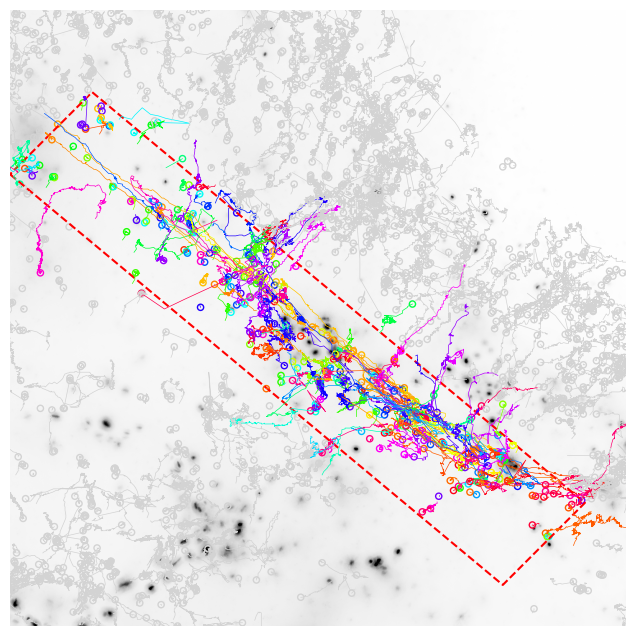

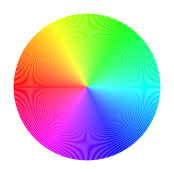

In [88]:
cmap_angle = plt.cm.hsv
roi = [3500, 5000, 2000,3500]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(*np.append(polygon, [polygon[0]], axis=0).T, 'k--', c='red')
ax.imshow(im, cmap='Greys')
ax.axis('off');

t = all_tracks.shape[-1]
for i in trange(all_tracks.shape[0]):
    if in_roi[i]:
        xy = all_tracks[i,:,:].reshape([2,t])
        valid = xy[1,:] > 0
        ax.plot(xy[1,valid], xy[0,valid], c=cmap_angle(final_angle[i]/360), lw=.5, alpha=1)
        ax.scatter(xy[1,np.where(valid)[0][-1]], xy[0,np.where(valid)[0][-1]], s=20, facecolors='none', edgecolors = cmap_angle(final_angle[i]/360))
    elif i in select_bg:
        xy = all_tracks[i,:,:].reshape([2,t])
        valid = xy[1,:] > 0
        ax.plot(xy[1,valid], xy[0,valid], c='lightgrey', lw=.5, alpha=1)
        ax.scatter(xy[1,np.where(valid)[0][-1]], xy[0,np.where(valid)[0][-1]], s=20, facecolors='none', edgecolors = 'lightgray')

ax.set_ylim([roi[3],roi[2]])
ax.set_xlim([roi[0],roi[1]])

## Color wheel
theta = np.linspace(0, 2* np.pi, 360) 
r = np.ones_like(theta)
colors = cmap_angle(theta / (2* np.pi))

fig, ax = plt.subplots(figsize=(2,2), subplot_kw={'projection': 'polar'})

bars = ax.bar(theta, r, width=np.radians(1), bottom=0, color=colors, edgecolor='none')
ax.set_theta_zero_location('W') ## Correct for moving angles by pi
ax.set_theta_direction(-1)

ax.set_yticklabels([])
ax.set_xticks(np.radians([0,90,180,270]))
ax.set_xticklabels([]);
ax.set_frame_on(False)
ax.grid(False)

/var/lib/condor/execute/dir_1159735/ipykernel_47522/4079042412.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax[id].plot(*np.append(polygon, [polygon[0]], axis=0).T, 'k--', c='red')
100%|██████████| 12845/12845 [00:00<00:00, 51075.23it/s]


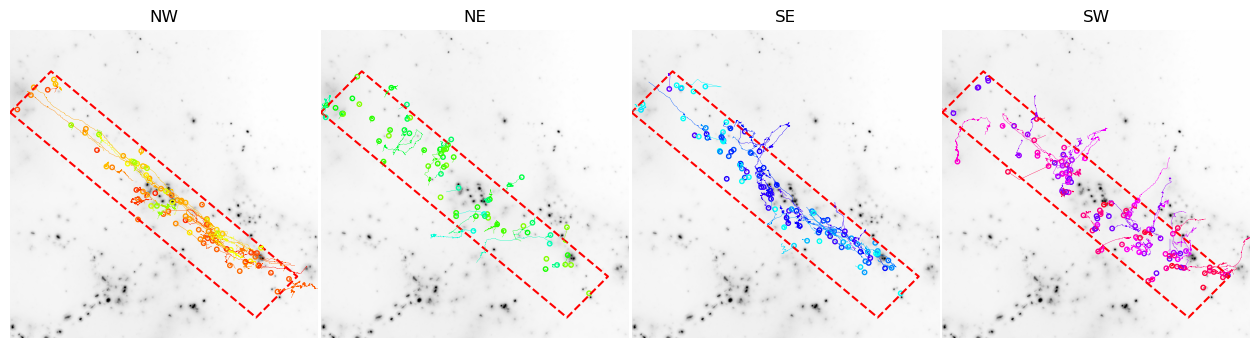

In [93]:
fig, ax = plt.subplots(1,4,figsize=(16,8))
ax = ax.flatten()

labels = ['NW', 'NE', 'SE', 'SW']
for id, rn in enumerate([[90,0],[180,90],[270,180],[360,270]]):
    mx, mn = rn
    ax[id].plot(*np.append(polygon, [polygon[0]], axis=0).T, 'k--', c='red')
    ax[id].imshow(im, cmap='Greys')
    ax[id].axis('off');
    
    t = ws.Coord.shape[-1]
    for i in trange(ws.cells.length):
        if in_roi[i]:
            xy = all_tracks[i,:,:].reshape([2,t])
            valid = xy[1,:] > 0
    
            if (final_angle[i] >= mn) & (final_angle[i] < mx):
                ax[id].plot(xy[1,valid], xy[0,valid], c=cmap_angle(final_angle[i]/360), lw=.25, alpha=1)
                ax[id].scatter(xy[1,np.where(valid)[0][-1]], xy[0,np.where(valid)[0][-1]], s=10, facecolors='none', edgecolors = cmap_angle(final_angle[i]/360))
            # else:
            #     ax[id].plot(xy[1,valid], xy[0,valid], c='lightgrey', lw=.25, alpha=1)
            #     ax[id].scatter(xy[1,np.where(valid)[0][-1]], xy[0,np.where(valid)[0][-1]], s=10, facecolors='none', edgecolors = 'lightgrey')
    
    ax[id].set_ylim([roi[3],roi[2]])
    ax[id].set_xlim([roi[0],roi[1]])
    ax[id].set_title(labels[id])
plt.subplots_adjust(wspace=0.01, hspace=0.01)

100%|██████████| 12845/12845 [00:00<00:00, 94062.23it/s]

Counter({'bg': 4062, 'across': 61, 'along': 59})
Meander
along v. across:  TtestResult(statistic=2.1065251797892857, pvalue=0.018638790084695274, df=118.0)
along v. bg:  TtestResult(statistic=6.487850256175824, pvalue=4.868657717415867e-11, df=4119.0)
across v. bg:  TtestResult(statistic=2.4862492394682367, pvalue=0.006474535179678639, df=4121.0)


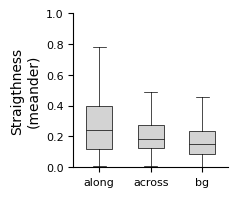

In [95]:
from scipy.stats import ttest_ind

df_metrics = pd.read_csv('data/EV39_metrics.csv')
all_tracks = np.load('data/EV39_tracks.npy')

cmap_directions = {'along': 'lightgrey',
                   'across': 'lightgrey',
                   'bg': 'lightgrey'}

direction, meander = [],[]
for i in trange(all_tracks.shape[0]):
    if df_metrics.Time_tracked[i] > 12:
        if in_roi[i]:
            if (final_angle[i] > 0) & (final_angle[i] <= 90):
                direction.append('along')
            elif (final_angle[i] > 90) & (final_angle[i] <= 180):
                direction.append('across')
            elif (final_angle[i] > 180) & (final_angle[i] <= 270):
                direction.append('along')
            elif (final_angle[i] > 270) & (final_angle[i] <= 360):
                direction.append('across')
        else:
            direction.append('bg')
        meander.append(df_metrics.Meandering[i])
df = pd.DataFrame.from_dict({'direction': np.array(direction), 'meander': np.array(meander)})
print(Counter(df['direction']))

boxprops={'linewidth':.5}
medianprops = {'color':'black', 'linewidth':.5}
groups = ['along', 'across', 'bg']

fig, ax = plt.subplots(figsize=(2,2))
bplots = []
values = [df.loc[df['direction'] == direction,'meander'].values for direction in groups]

print('Meander')
print('along v. across: ', ttest_ind(values[0], values[1], alternative='greater'))
print('along v. bg: ', ttest_ind(values[0], values[2], alternative='greater'))
print('across v. bg: ', ttest_ind(values[1], values[2], alternative='greater'))

for i, g in enumerate(groups):
    bplots.append(ax.boxplot(values[i],positions=[i], widths=[.5], patch_artist=True, showfliers = False, vert= True,
                             boxprops = boxprops, medianprops=medianprops, whiskerprops=boxprops, capprops=boxprops))
for i, bplot in enumerate(bplots):
    for patch in bplot['boxes']:
        patch.set_facecolor(cmap_directions[groups[i]])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks([0,1,2], groups)
plt.ylim([0,1])
plt.gca().tick_params(axis='both', which='major', labelsize=8)
plt.ylabel('Straigthness\n(meander)');

In [30]:
from scipy.stats import ttest_ind
from scipy.stats import sem
from statistics import mean, stdev
from math import sqrt

print(f"Along Mean: {np.mean(df.loc[df['direction'] == 'along','meander'].values)} - {sem(df.loc[df['direction'] == 'along','meander'].values)}")
print(f"Acorss Mean: {np.mean(df.loc[df['direction'] == 'across','meander'].values)} - {sem(df.loc[df['direction'] == 'across','meander'].values)}")
print(f"Background Mean: {np.mean(df.loc[df['direction'] == 'bg','meander'].values)} - {sem(df.loc[df['direction'] == 'bg','meander'].values)}")

t = ttest_ind(df.loc[df['direction'] == 'along','meander'].values, 
                     df.loc[df['direction'] == 'across','meander'].values, alternative='greater')
print(f'\nAlong v. across: {t}')
print(f'Along v. across CI: {t.confidence_interval()}')
c0 = df.loc[df['direction'] == 'along','meander'].values
c1 = df.loc[df['direction'] == 'across','meander'].values
cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
print(f"Cohen' D: {cohens_d}")

t = ttest_ind(df.loc[df['direction'] == 'along','meander'].values, 
                                   df.loc[df['direction'] == 'bg','meander'].values, alternative='greater')
print(f'\nAlong v. bg: {t}')
print(f'Along v. bg CI: {t.confidence_interval()}')
c0 = df.loc[df['direction'] == 'along','meander'].values
c1 = df.loc[df['direction'] == 'bg','meander'].values
cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
print(f"Cohen' D: {cohens_d}")

Along Mean: 0.2861328125 - 0.026381053738789993
Acorss Mean: 0.2186279296875 - 0.01845844179696657
Background Mean: 0.1783447265625 - 0.0019631973638770442

Along v. across: TtestResult(statistic=2.1077019421926324, pvalue=0.018586762225458804, df=118.0)
Along v. across CI: ConfidenceInterval(low=0.014407105765572421, high=inf)
Cohen' D: 0.38379094286300514

Along v. bg: TtestResult(statistic=6.491758713766437, pvalue=4.745227716690442e-11, df=4119.0)
Along v. bg CI: ConfidenceInterval(low=0.08047106512612688, high=inf)
Cohen' D: 0.639728778471026
